In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import  r2_score, mean_absolute_error
import warnings
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from  genre_label_helpers import *
warnings.filterwarnings("ignore", category=Warning)  # Suppress all warnings

In [22]:
metadata_df = pd.read_csv('nik_things/movies_metadata_ratings.csv')
genres_df = metadata_df[['movie_genres','wiki_movie_id']].copy()
genres_df['movie_genres'] = genres_df['movie_genres'].apply(transform_genres_string)
genres_df = genres_df['movie_genres']


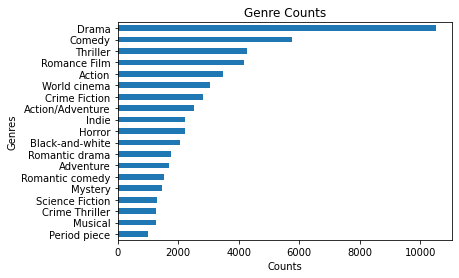

Mean absolute error of linear regression on genres is  0.7522418622904269


In [23]:
THRESHOLD = 100
genres_filtered_df = filter_genres(genres_df, 1000, True)
dummy_variables = get_genre_dummies(genres_filtered_df)
genres_df = dummy_variables.merge(metadata_df['averageRating'], left_index=True, right_index= True, how='left').copy()
X_column_names = [col for col in genres_df.columns if col != 'averageRating' ]
y_column_names = ['averageRating']
model_genres, mae = linear_regression(X_column_names,y_column_names, genres_df)
print("Mean absolute error of linear regression on genres is ",mae)

# Predicting Movie rating soleley on genre information

Running linear regression with a 0.8/0.2 or 0.85/0.15 train/test split, we get a mean absolute error of 0.72 for a threshold of 750 (meaning genres with less than 750 representatives aaren't represented), we coul use a stricter or more loosse threshold, the result doesn't change all that much. It would be interresting to if the time when the film went out plays a role in the films' sucess.

In [24]:
show_model(model_genres)

How certain can we be of our guess, when predicting on genres? Data shows, that it doesn't purely depend on the genre in question (cf model results and p-values of different coefficients, represented on this graph) but also on the year in question. Running linear regression on data grouped by yars, we can see a steady risse in error, indicating more unceartainty present in recent years. A logical observation would be to account for more recent films in our data in addition to older films haven gone through the proof of time.

or someething like:  as we can see, the uncertainty grows with the years. First of all, we have to remember that our data has more releses closer to the present. Logically, the films that "stood the test of time" and found their way into the dataset are more likely to be of better quality, since they have not been forgotten, while the modern creations find their way into lists without any paticular trrouble.

# Looking at errors when training and testing on the same year

In [5]:
years = list(range(1930, 2020, 5))
errors = []
for year in years:
    df = metadata_df.copy()
    filt_metadata_df = df[metadata_df['movie_release_year'] < year]
    filt_metadata_df = filt_metadata_df[filt_metadata_df['movie_release_year'] >= year-5]
    errors.append(full_genre_process(filt_metadata_df, 100)[1])

fig = go.Figure(data=go.Scatter(x=years, y=errors, mode='lines+markers'))
fig.update_layout(title='Linear Regression Mean Absolute Error for a given 5 year period',
                  xaxis_title='Years',
                  yaxis_title='Mean Absolute Error')
fig.show()


In [6]:

# Plot 1: Average Rating per Year (Line Plot)
df = metadata_df[metadata_df['movie_release_year']>1920].copy().groupby('movie_release_year')['averageRating'].mean().reset_index()
# Create a line trace for "Average Rating per Year"
line_trace = go.Scatter(
    x=df['movie_release_year'],
    y=df['averageRating'],
    mode='lines',
    name='Average Rating',
    line=dict(color='blue'),  # Customize line color
)

# Create a layout
layout = go.Layout(
    title='Average Rating per Year',
    xaxis=dict(title='Years'),
    yaxis=dict(title='Average Rating'),
)
fig1 = go.Figure(data=[line_trace], layout=layout)
fig1.update_xaxes(title_text='Years')
fig1.update_yaxes(title_text='Average Rating')

# Plot 2: Distribution of Top 1000 Movies by Year (Histogram)
df_top_1000 = metadata_df.sort_values(by='averageRating', ascending=False).head(1000)
fig2 = px.histogram(df_top_1000, x='movie_release_year', nbins=10, title='Distribution of Top 1000 Movies by Year')
fig2.update_xaxes(title_text='Years')
fig2.update_yaxes(title_text='Counts')

# Create a subplot with two plots vertically
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=2, col=1)

# Update layout and titles
fig.update_layout(height=600, title_text="Average Ratings per year vs Top 1000 Movie Distribution Over Years")

# Show the plot
fig.show()



# Where them good fims at?
A as we can see, the avarrage ratting of films seems to go down throughouut years, yet if we analise the top 1000 movies, we see that they are more likeley to be found in the recent years. Considering that the evaluation of movie genres wasn't quite sufficient, why not try gain more information on their "vibe" by analising the plots. Such analysis can be conducted with the aid of NLP tools, it is however important to reflect on what sort of information we want to use. 

Having observed the different prrertrained models and their caapabilaties (as much as the capabilaties of our hardware), it seemed that an interesting aproach would be utilizing the zero-shot-classification capabilaty of DeBERTa-v3-base-mnli-fever-anli, a pretrained and fine-tuned model we found on hugging face. Given a text and a list of labels as input, the model assigns probabilaties to each of the labels (together summing to 1). Thus, an interesting aprroach would be to create multiple lists with emelements from similar groups and running thee model on all the texts and lists, get orer informattion about the time period described in the plot, a particular way the plot was constructed, what sort of problem is the story constructed around etc. 

Since this is a computation heavy process, it was decided to only run in on parrt of our dataset, nameley films coming out after 1980 and having more than 1000 votes. This still gave us 9900 samples to worrk with.


In [38]:
metadata_df = pd.read_csv('nik_things/movies_metadata_ratings.csv')
metadata_df = metadata_df.set_index('wiki_movie_id')
metadata_df = metadata_df[metadata_df['movie_release_year'] > 1980].copy()
metadata_df = metadata_df[metadata_df['numVotes'] > 1000].copy()


In [53]:
rating_labels = create_labels_df(threshold = 0.4, path_to_file = 'data/DeBERTa-v3/complete_De-BERTa_plots.csv')
rating_labels, labels = filter_labels(rating_labels,10,600)
print("number of labels left after filtering is ", len(labels))
rating_labels.shape

number of labels left after filtering is  151


(8161,)

In [54]:
show_label_counts(rating_labels,20)

In [55]:
labels_rattings_df = pd.DataFrame(rating_labels).merge(metadata_df['averageRating'], left_index=True, right_index=True, how='left').copy()
show_label_means(labels_rattings_df,10)

fianlly, we perform a linear regression on the data

In [56]:
dummy_labels = get_label_dummies(rating_labels)
dummy_labels_rating = dummy_labels.merge(metadata_df['averageRating'], left_index=True, right_index=True, how='left').copy()
model, mal = linear_regression(dummy_labels.columns,['averageRating'], dummy_labels_rating)
print("mean abssolute losss when doing linear regreession is: ", mal )


mean abssolute losss when doing linear regreession is:  0.8172447844553773


we then check how will the same samples would compare if we try to predict soleley on their genre data

In [57]:
df = metadata_df.copy()
df = df.loc[rating_labels.index]
genre_model , genre_mal = full_genre_process(df, 100)
print("mean abssolute losss when doing linear regreession on genre column is: ", genre_mal )

mean abssolute losss when doing linear regreession on genre column is:  0.7247300034084618


In [58]:
show_model(model)

As we can see, the confidence intervals are larger than in the case of genres and the most influentual labels are those that correlate the modst with a specific genre, however this is more information we can work with and it seems to be menaingful in one way or another. Now, it would be interesting to combine thhe knowledge we have on genres and labels together in order to get a more specialised model.

In [59]:
df = metadata_df['movie_genres'].copy().apply(lambda x: transform_genres_string(x))
df = df.loc[rating_labels.index]
df = get_genre_dummies(df)
df = df.merge(dummy_labels_rating, left_index=True, right_index=True, how='left')
combined_model, combined_mae = linear_regression(df.columns[:-1],['averageRating'], df)
print("mean abssolute losss when doing linear regreession on genre combined with labels is: ", combined_mae )


mean abssolute losss when doing linear regreession on genre combined with labels is:  0.723361197873822


In [60]:
show_model(combined_model)